In [1]:
# Imports
import sys
sys.path.append('..')  # Add parent directory to path

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# yfinance fix für Yahoo Finance Rate Limiting
import yfinance_fix

# Our modules
from tradbot.portfolio import (
    calculate_expected_returns,
    calculate_covariance_matrix,
    optimize_max_sharpe,
    optimize_min_volatility,
    get_efficient_frontier
)
from tradbot.risk import (
    calculate_sharpe_ratio,
    calculate_max_drawdown,
    calculate_var
)

[yfinance_fix] Patch erfolgreich angewendet.
[yfinance_fix] Chrome-Session erstellt.


In [2]:
# Tickers auswählen
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']

# Historische Preise laden (2 Jahre) - mit chrome_session für Rate Limiting
prices = yf.download(tickers, period='2y', session=yfinance_fix.chrome_session)['Close']
prices.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2024-01-24,192.680328,156.869995,147.584885,387.989746,396.646088
2024-01-25,192.353424,157.750000,150.731110,390.452576,398.922119
2024-01-26,190.619781,159.119995,151.048721,391.405884,397.995911
2024-01-29,189.936264,161.259995,152.358795,398.238190,403.700867
2024-01-30,186.280777,159.000000,150.324203,397.284821,402.587463


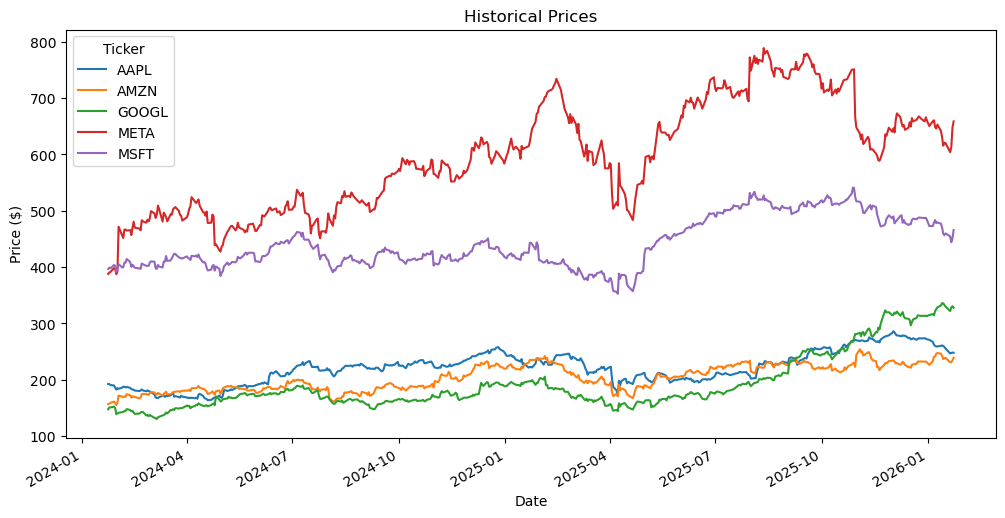

In [3]:
# Quick check: Preise plotten
prices.plot(figsize=(12, 6), title='Historical Prices')
plt.ylabel('Price ($)')
plt.show()

In [4]:
# Expected Returns berechnen
mu = calculate_expected_returns(prices)
print("Expected Annual Returns:")
print(mu.sort_values(ascending=False))

Expected Annual Returns:
Ticker
GOOGL    0.494197
META     0.305094
AMZN     0.236297
AAPL     0.135457
MSFT     0.084370
dtype: float64


In [5]:
# Covariance Matrix
S = calculate_covariance_matrix(prices)
print("Covariance Matrix:")
S

Covariance Matrix:


Ticker,AAPL,AMZN,GOOGL,META,MSFT
Ticker,,,,,
AAPL,0.077655,0.041616,0.037216,0.038980,0.029250
AMZN,0.041616,0.099999,0.050649,0.074179,0.044290
GOOGL,0.037216,0.050649,0.091770,0.046400,0.031721
META,0.038980,0.074179,0.046400,0.140287,0.051252
MSFT,0.029250,0.044290,0.031721,0.051252,0.050479


In [6]:
# Maximum Sharpe Ratio Portfolio
weights_sharpe, perf_sharpe = optimize_max_sharpe(prices)

print("=== MAX SHARPE PORTFOLIO ===")
print("\nWeights:")
for ticker, weight in weights_sharpe.items():
    if weight > 0.01:  # Nur Gewichte > 1% anzeigen
        print(f"  {ticker}: {weight:.2%}")

print(f"\nPerformance:")
print(f"  Expected Return: {perf_sharpe[0]:.2%}")
print(f"  Volatility:      {perf_sharpe[1]:.2%}")
print(f"  Sharpe Ratio:    {perf_sharpe[2]:.2f}")

=== MAX SHARPE PORTFOLIO ===

Weights:
  GOOGL: 92.76%
  META: 7.24%

Performance:
  Expected Return: 48.05%
  Volatility:      29.31%
  Sharpe Ratio:    1.57


In [7]:
# Minimum Volatility Portfolio
weights_minvol, perf_minvol = optimize_min_volatility(prices)

print("=== MIN VOLATILITY PORTFOLIO ===")
print("\nWeights:")
for ticker, weight in weights_minvol.items():
    if weight > 0.01:
        print(f"  {ticker}: {weight:.2%}")

print(f"\nPerformance:")
print(f"  Expected Return: {perf_minvol[0]:.2%}")
print(f"  Volatility:      {perf_minvol[1]:.2%}")
print(f"  Sharpe Ratio:    {perf_minvol[2]:.2f}")

=== MIN VOLATILITY PORTFOLIO ===

Weights:
  AAPL: 24.55%
  GOOGL: 15.48%
  MSFT: 59.98%

Performance:
  Expected Return: 16.03%
  Volatility:      20.58%
  Sharpe Ratio:    0.68


In [8]:
# Efficient Frontier berechnen
frontier = get_efficient_frontier(prices, n_points=50)
frontier.head()

,return,volatility
0,0.160346,0.205827
1,0.160346,0.205827
2,0.160346,0.205827
3,0.160346,0.205827
4,0.160346,0.205827


/var/folders/jj/9j0c_6196zx24tx5jb3ngnym0000gn/T/ipykernel_28595/2442895656.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (individual_vols[i], individual_returns[i]),


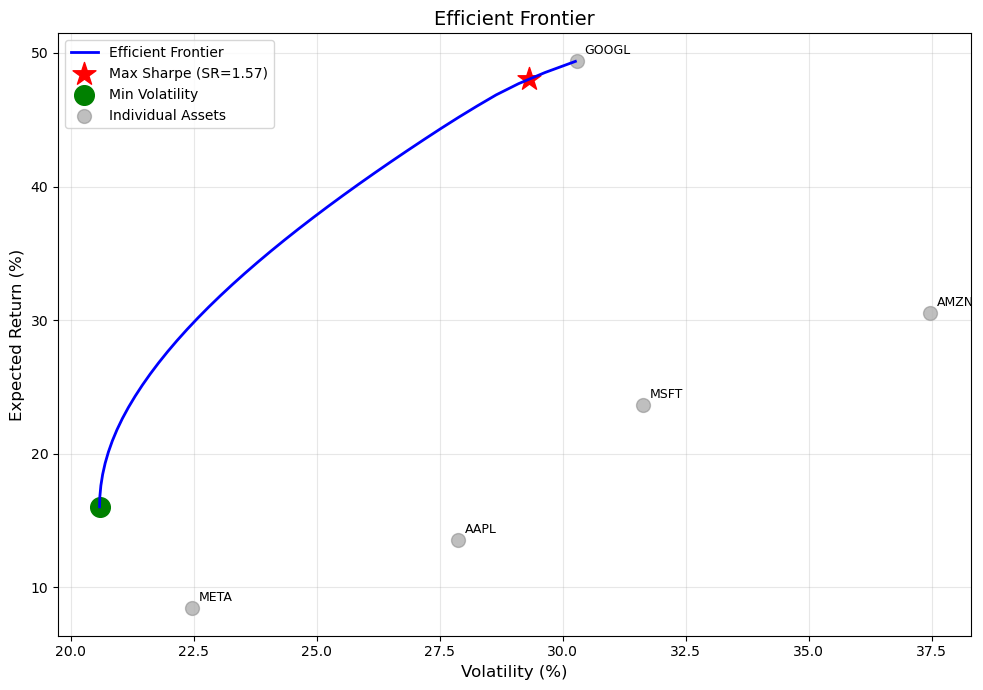

In [9]:
# Plot Efficient Frontier
plt.figure(figsize=(10, 7))

# Efficient Frontier Kurve
plt.plot(
    frontier['volatility'] * 100, 
    frontier['return'] * 100, 
    'b-', 
    linewidth=2, 
    label='Efficient Frontier'
)

# Max Sharpe Portfolio (roter Stern)
plt.scatter(
    perf_sharpe[1] * 100, 
    perf_sharpe[0] * 100, 
    marker='*', 
    s=300, 
    c='red', 
    label=f'Max Sharpe (SR={perf_sharpe[2]:.2f})'
)

# Min Volatility Portfolio (grüner Punkt)
plt.scatter(
    perf_minvol[1] * 100, 
    perf_minvol[0] * 100, 
    marker='o', 
    s=200, 
    c='green', 
    label='Min Volatility'
)

# Individual Assets (graue Punkte)
individual_returns = mu * 100
individual_vols = np.sqrt(np.diag(S)) * 100
plt.scatter(
    individual_vols, 
    individual_returns, 
    marker='o', 
    s=100, 
    c='gray', 
    alpha=0.5,
    label='Individual Assets'
)

# Asset Labels
for i, ticker in enumerate(tickers):
    plt.annotate(
        ticker, 
        (individual_vols[i], individual_returns[i]),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=9
    )

plt.xlabel('Volatility (%)', fontsize=12)
plt.ylabel('Expected Return (%)', fontsize=12)
plt.title('Efficient Frontier', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

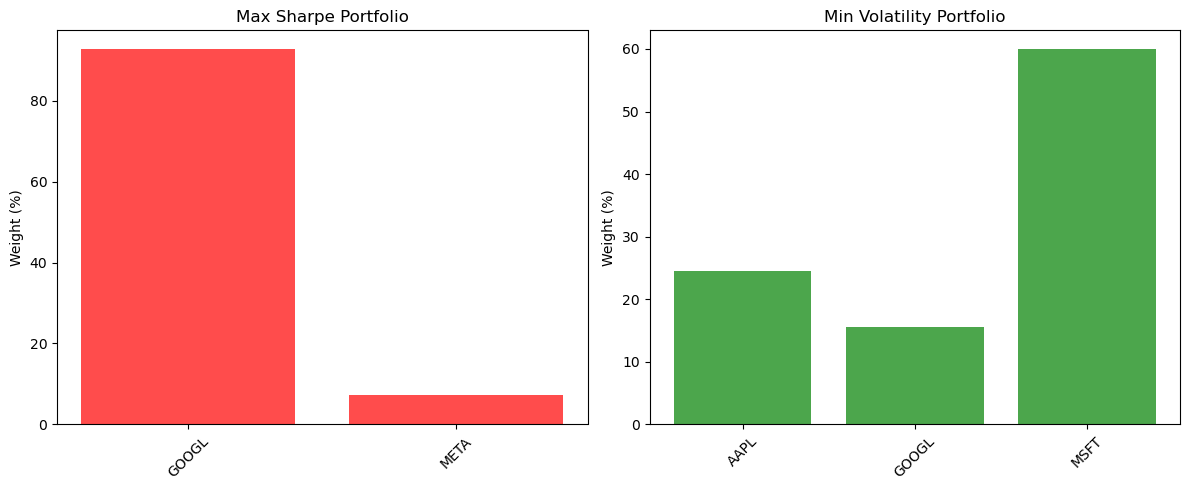

In [10]:
# Bar Chart: Weights Comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Max Sharpe Weights
weights_df_sharpe = pd.Series(weights_sharpe)
weights_df_sharpe = weights_df_sharpe[weights_df_sharpe > 0.01]
axes[0].bar(weights_df_sharpe.index, weights_df_sharpe.values * 100, color='red', alpha=0.7)
axes[0].set_title('Max Sharpe Portfolio')
axes[0].set_ylabel('Weight (%)')
axes[0].tick_params(axis='x', rotation=45)

# Min Volatility Weights
weights_df_minvol = pd.Series(weights_minvol)
weights_df_minvol = weights_df_minvol[weights_df_minvol > 0.01]
axes[1].bar(weights_df_minvol.index, weights_df_minvol.values * 100, color='green', alpha=0.7)
axes[1].set_title('Min Volatility Portfolio')
axes[1].set_ylabel('Weight (%)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [11]:
# Daily Returns berechnen
returns = prices.pct_change().dropna()

# Portfolio Returns (mit Max Sharpe Weights)
portfolio_returns = (returns * pd.Series(weights_sharpe)).sum(axis=1)

# Portfolio Prices (für Drawdown)
portfolio_prices = (1 + portfolio_returns).cumprod() * 100  # Start bei 100

print("=== RISK METRICS (Max Sharpe Portfolio) ===")
print(f"Sharpe Ratio:    {calculate_sharpe_ratio(portfolio_returns):.2f}")
print(f"Max Drawdown:    {calculate_max_drawdown(portfolio_prices):.2%}")
print(f"VaR (95%):       {calculate_var(portfolio_returns, 0.95):.2%}")

=== RISK METRICS (Max Sharpe Portfolio) ===
Sharpe Ratio:    1.43
Max Drawdown:    -29.59%
VaR (95%):       -2.62%


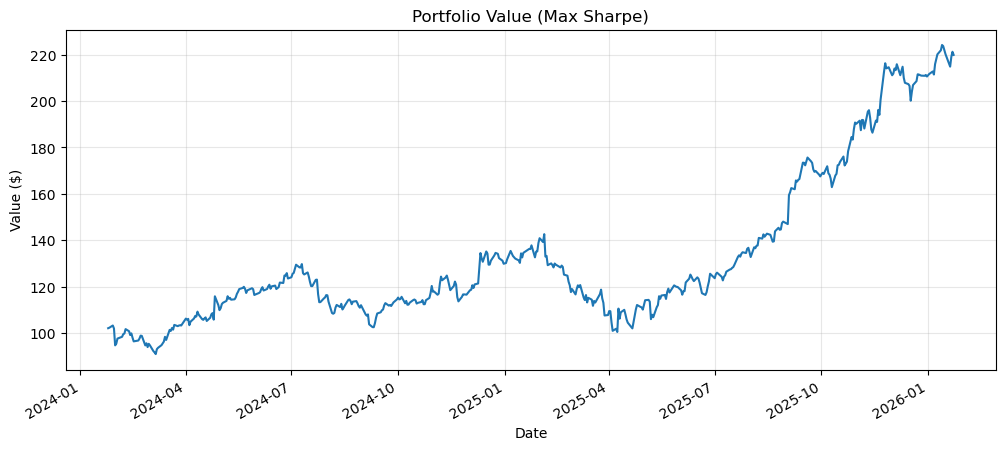

In [12]:
# Portfolio Value über Zeit
plt.figure(figsize=(12, 5))
portfolio_prices.plot()
plt.title('Portfolio Value (Max Sharpe)')
plt.ylabel('Value ($)')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.show()